# Export & Inference testing
Generate example classifier ensemble and export. Data is from HiggsML challenge.

In [ ]:
!mkdir data
!wget -O data/atlas-higgs-challenge-2014-v2.csv.gz http://opendata.cern.ch/record/328/files/atlas-higgs-challenge-2014-v2.csv.gz
!gunzip data/atlas-higgs-challenge-2014-v2.csv.gz

### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from pathlib import Path
from functools import partial
from typing import Union

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lumin.data_processing.pre_proc import fit_input_pipe
from lumin.data_processing.pre_proc import proc_cats
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.data.fold_yielder import FoldYielder
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.helpers import CatEmbedder
from lumin.optimisation.hyper_param import fold_lr_find
from lumin.nn.callbacks.cyclic_callbacks import OneCycle
from lumin.nn.metrics.class_eval import AMS
from lumin.data_processing.hep_proc import proc_event
from lumin.utils.misc import ids2unique
from lumin.nn.training.fold_train import fold_train_ensemble
from lumin.nn.ensemble.ensemble import Ensemble

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
PATH = Path('data/')

## Data preparation

### Data import from CSV file 
Read file into a pandas dataframe.

In [3]:
data = pd.read_csv(PATH/'atlas-higgs-challenge-2014-v2.csv')

In [4]:
data.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [5]:
data.drop(columns=['Weight'], inplace=True)
data['Label'] = data['Label'].map({'s':1, 'b':0})
data.rename(index=str, columns={"KaggleWeight": "gen_weight", 'PRI_met': 'PRI_met_pt', 'Label':'gen_target'}, inplace=True)

df = pd.DataFrame(data.loc[data.KaggleSet == 't'])
df.drop(columns=['KaggleSet'], inplace=True)

### Preprocessing
Apply pre-processing of the 3-momenta.

In [6]:
print([f for f in df.columns])

['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_pt', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt', 'gen_target', 'gen_weight']


In [8]:
proc_event(df, use_cartesian=True, default_vals=[-999.0], keep_feats=['PRI_met_pt'],
           ref_vec_0='PRI_lep', ref_vec_1='PRI_tau', fix_phi=True, fix_y=True, fix_z=True)

Setting PRI_lep to phi = 0
Setting PRI_tau to positve phi
Setting PRI_lep to positive eta
eta component of PRI_met not found
Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use.

In [9]:
targ_feat = 'gen_target'
gen_feats = [f for f in df.columns if 'gen_' in f]
misc_feats = ['EventId']
wgt_feat = 'gen_weight'
cat_feats = ['PRI_jet_num']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats+misc_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

1 ['PRI_jet_num']
29 ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_pt']


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories and classes in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [10]:
df['gen_strat_key'] = ids2unique(df[[targ_feat] + cat_feats].values)

In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
df.columns[df.isna().any()].tolist()

['DER_mass_MMC',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_lep_eta_centrality',
 'PRI_jet_subleading_px',
 'PRI_jet_subleading_py',
 'PRI_jet_subleading_pz',
 'PRI_jet_leading_px',
 'PRI_jet_leading_py',
 'PRI_jet_leading_pz']

We've got some NaNs in the data, however this is due to non-existent jets, float precision, and algorithm non-convergence. `FoldYielder` automatically applied `np.nan_to_num` so no worries.

### Data halving
Split data in half to simulate training a pair of ensembles on halves of data

In [17]:
set_0, set_1 = train_test_split(df.copy(), test_size=0.5, stratify=df.gen_strat_key, random_state=42)

#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [18]:
input_pipe_0 = fit_input_pipe(set_0, cont_feats, PATH/'input_pipe_0')
input_pipe_1 = fit_input_pipe(set_1, cont_feats, PATH/'input_pipe_1')

In [19]:
set_0[cont_feats] = input_pipe_0.transform(set_0[cont_feats])
set_1[cont_feats] = input_pipe_1.transform(set_1[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [22]:
cat_maps, cat_szs = proc_cats(df, cat_feats)
cat_maps, cat_szs

(OrderedDict([('PRI_jet_num', {0: 0, 1: 1, 2: 2, 3: 3})]),
 OrderedDict([('PRI_jet_num', 4)]))

### Weight processing
The data contains weights which are important to consider as they indicate which events are the most important to consider and are necessary to correctly compute the AMS at the end. However the data also contains an imbalance between signal and background in terms of raw event numbers. We can correct for this imbalance by renormalising the weights such that the sum for signal and background are equal, however since we might also want to compute the AMS on the training data, we'll make a copy of the column first.

In [23]:
set_0['gen_orig_weight'] = set_0['gen_weight']
set_0.loc[set_0.gen_target == 0, 'gen_weight'] /= np.sum(set_0.loc[set_0.gen_target == 0, 'gen_weight'])
set_0.loc[set_0.gen_target == 1, 'gen_weight'] /= np.sum(set_0.loc[set_0.gen_target == 1, 'gen_weight'])

In [24]:
set_1['gen_orig_weight'] = set_1['gen_weight']
set_1.loc[set_1.gen_target == 0, 'gen_weight'] /= np.sum(set_1.loc[set_1.gen_target == 0, 'gen_weight'])
set_1.loc[set_1.gen_target == 1, 'gen_weight'] /= np.sum(set_1.loc[set_1.gen_target == 1, 'gen_weight'])

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [25]:
df2foldfile(df=set_0, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['gen_orig_weight'],
            savename=PATH/'set_0', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 12503 events
Saving fold 1 with 12503 events
Saving fold 2 with 12503 events
Saving fold 3 with 12502 events
Saving fold 4 with 12502 events
Saving fold 5 with 12501 events
Saving fold 6 with 12498 events
Saving fold 7 with 12496 events
Saving fold 8 with 12496 events
Saving fold 9 with 12496 events


In [26]:
df2foldfile(df=set_1, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feat,
            wgt_feat=wgt_feat, misc_feats=misc_feats+['gen_orig_weight'],
            savename=PATH/'set_1', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 12504 events
Saving fold 1 with 12503 events
Saving fold 2 with 12502 events
Saving fold 3 with 12502 events
Saving fold 4 with 12502 events
Saving fold 5 with 12500 events
Saving fold 6 with 12499 events
Saving fold 7 with 12496 events
Saving fold 8 with 12496 events
Saving fold 9 with 12496 events


In [27]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feat, 'cont_feats': cont_feats, 'cat_feats': cat_feats,
                 'cat_maps': cat_maps, 'cat_szs': cat_szs}, fout)

## Train classifier

Now we're ready to begin training the network-based classifier. First we can load the feature sets, create a `FoldYielder` for the training data.

In [29]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feats = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']
    train_feats = cont_feats + cat_feats

In [63]:
train_0_fy = FoldYielder(PATH/'set_0.hdf5', cont_feats, cat_feats, input_pipe=PATH/'input_pipe_0.pkl')
train_1_fy = FoldYielder(PATH/'set_1.hdf5', cont_feats, cat_feats, input_pipe=PATH/'input_pipe_1.pkl')

In [35]:
bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':31, 'depth':6, 'do':0.1, 'dense':True}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_0_fy)

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)

print("\nTraining on", len(cont_feats), " continuous features:", [var for var in cont_feats])
print("\nTraining on", len(cat_feats), " categorical features:", [var for var in cat_feats])
print(Model(model_builder))


Training on 29  continuous features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_met_pt']

Training on 1  categorical features: ['PRI_jet_num']
Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 2)
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=31, out_features=31, bias=True)
        (1): Swish()
        (2): Dropout(p=0.1)
      )
      (1): Sequential(

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots to mean and standard deviation of the loss.

LR finder took 2.080s 


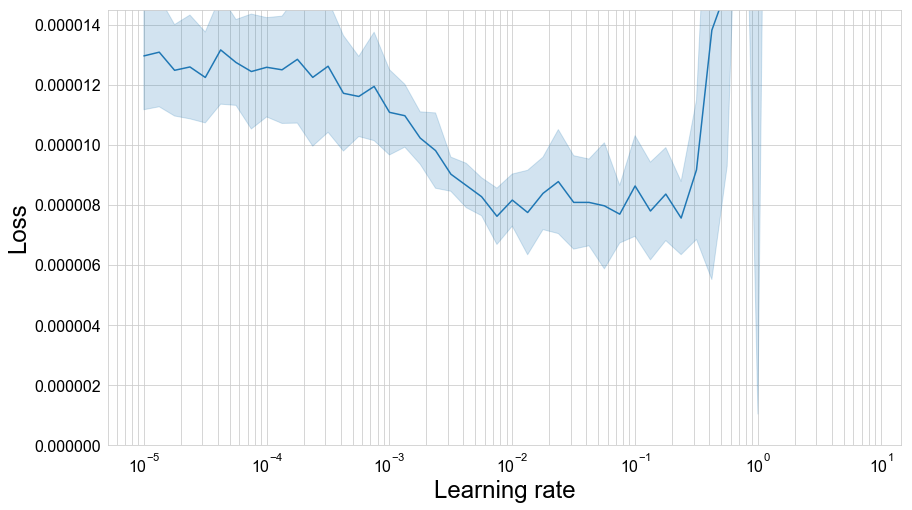

In [37]:
lr_finder = fold_lr_find(train_0_fy, model_builder, bs, lr_bounds=[1e-5,1e1])

In [53]:
n_models = 5

callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[6e-3, 6e-3],
                             mom_range=(0.85, 0.95), interp='cosine')]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_orig_weight')}
train_func = partial(fold_train_ensemble,
                     n_models=n_models,
                     model_builder=model_builder,
                     bs=bs,
                     callback_partials=callback_partials,
                     eval_metrics=eval_metrics,
                     max_epochs=15, patience=15)

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 5, Val ID = 0


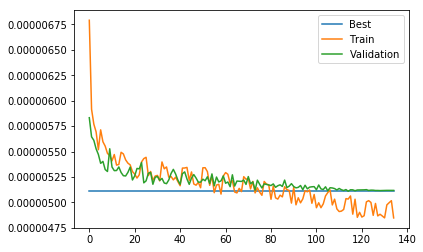

Early stopping after 135 epochs
Scores are: {'loss': 5.110091933602234e-06, 'AMS': 3.769222049634984}
Fold took 45.815s

Training model 2 / 5, Val ID = 1


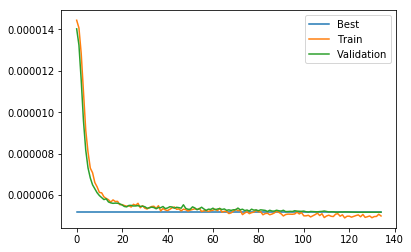

Early stopping after 135 epochs
Scores are: {'loss': 5.172066266823094e-06, 'AMS': 3.789013550417072}
Fold took 44.417s

Training model 3 / 5, Val ID = 2


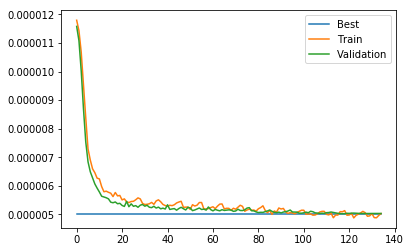

Early stopping after 135 epochs
Scores are: {'loss': 5.025127848057309e-06, 'AMS': 3.636404394540381}
Fold took 44.384s

Training model 4 / 5, Val ID = 3


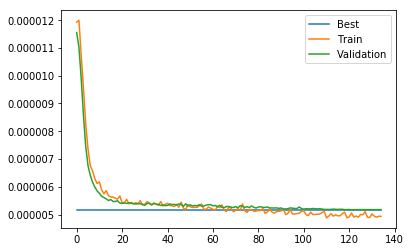

Early stopping after 135 epochs
Scores are: {'loss': 5.174379566597054e-06, 'AMS': 3.8020816072817234}
Fold took 44.356s

Training model 5 / 5, Val ID = 4


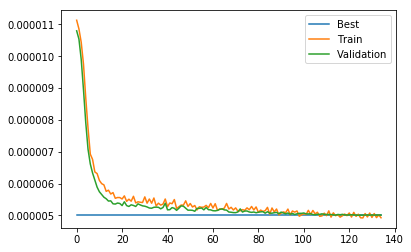

Early stopping after 135 epochs
Scores are: {'loss': 5.0059688874171115e-06, 'AMS': 4.054937160964254}
Fold took 44.611s


______________________________________
Training finished
Cross-validation took 223.585s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

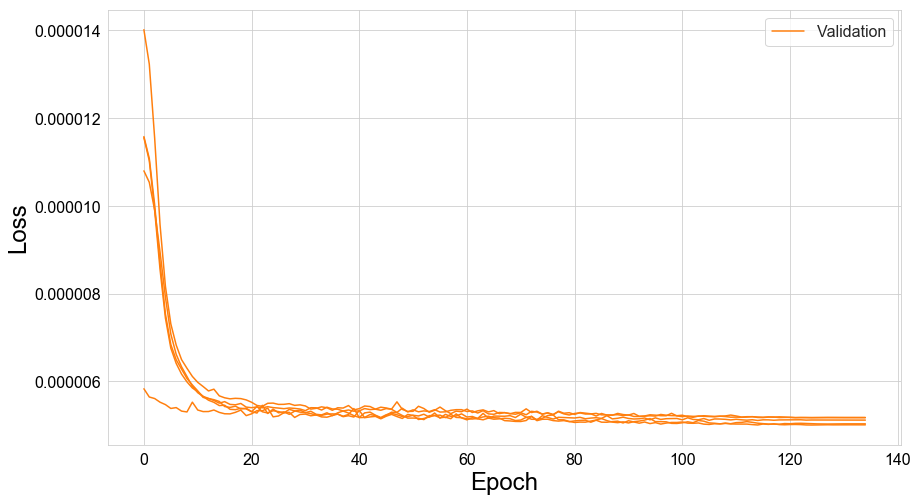

Mean loss = 5.1e-06±3e-08
Mean AMS = 3.81±0.06
______________________________________



In [48]:
results_0 = train_func(train_0_fy, savepath=Path('train_weights_0'))

Training model 1 / 5, Val ID = 0


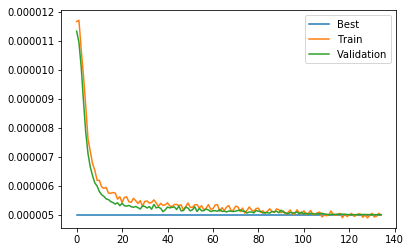

Early stopping after 135 epochs
Scores are: {'loss': 5.007285380997928e-06, 'AMS': 4.272769974320235}
Fold took 44.843s

Training model 2 / 5, Val ID = 1


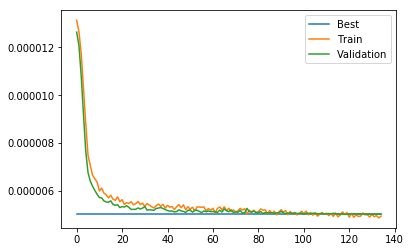

Early stopping after 135 epochs
Scores are: {'loss': 5.023918674851302e-06, 'AMS': 3.461042430873245}
Fold took 45.021s

Training model 3 / 5, Val ID = 2


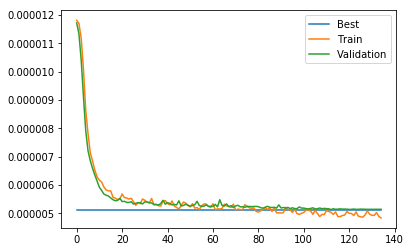

Early stopping after 135 epochs
Scores are: {'loss': 5.137294465384912e-06, 'AMS': 4.01656632389301}
Fold took 44.198s

Training model 4 / 5, Val ID = 3


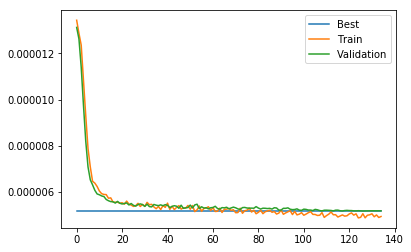

Early stopping after 135 epochs
Scores are: {'loss': 5.1637548494909424e-06, 'AMS': 3.8860608501269778}
Fold took 43.567s

Training model 5 / 5, Val ID = 4


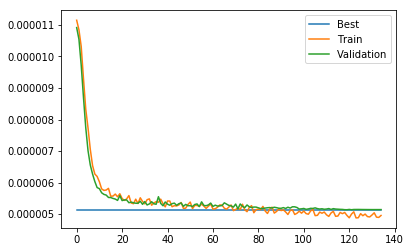

Early stopping after 135 epochs
Scores are: {'loss': 5.136747859069146e-06, 'AMS': 4.215754823337901}
Fold took 45.197s


______________________________________
Training finished
Cross-validation took 222.830s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

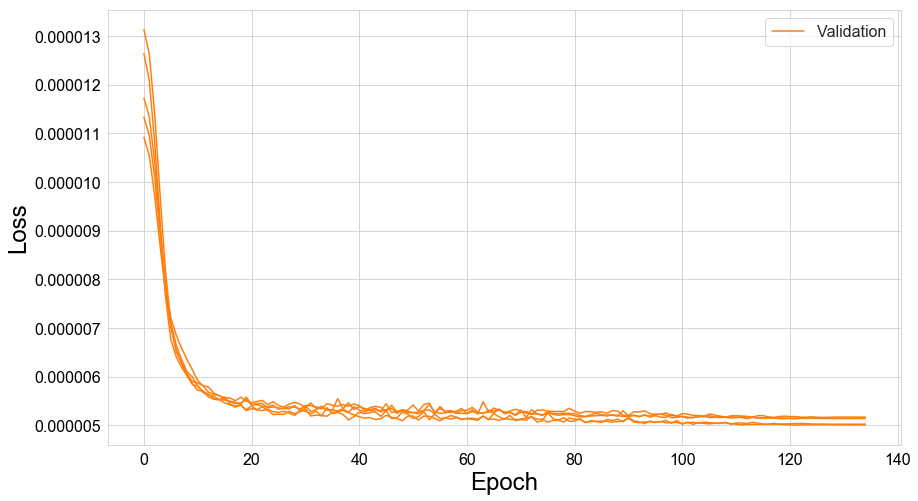

Mean loss = 5.09e-06±3e-08
Mean AMS = 4.0±0.1
______________________________________



In [49]:
results_1 = train_func(train_1_fy, savepath=Path('train_weights_1'))

## Ensemble loading
We can now build an ensemble from the trained models, however rather than simply treating them all equally, we can weight them according to some metric (e.g. AMS, reciprocal of loss).

In [55]:
ensemble_0 = Ensemble.from_results(results_0[0], n_models, model_builder, location=Path('train_weights_0'))
ensemble_1 = Ensemble.from_results(results_1[0], n_models, model_builder, location=Path('train_weights_1'))

Choosing ensemble by loss


Model 0 is 4 with loss = 5.0059688874171115e-06
Model 1 is 2 with loss = 5.025127848057309e-06
Model 2 is 0 with loss = 5.110091933602234e-06
Model 3 is 1 with loss = 5.172066266823094e-06
Model 4 is 3 with loss = 5.174379566597054e-06
Choosing ensemble by loss


Model 0 is 0 with loss = 5.007285380997928e-06
Model 1 is 1 with loss = 5.023918674851302e-06
Model 2 is 4 with loss = 5.136747859069146e-06
Model 3 is 2 with loss = 5.137294465384912e-06
Model 4 is 3 with loss = 5.1637548494909424e-06


In [58]:
ensemble_0.save('models/ensemble_0/example', feats=train_feats, overwrite=True)
ensemble_1.save('models/ensemble_1/example', feats=train_feats, overwrite=True)

## Ensemble export to TensorFlow

In [59]:
ensemble_0.export2tfpb('models/ensemble_0/example_TF')

/home/giles/anaconda3/lib/python3.6/site-packages/onnx_tf/common/__init__.py:87: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use keras.layers.flatten instead.


/home/giles/cernbox/lumin/lumin/nn/models/model.py:399: UserWarning: Tensorflow ProtocolBuffer export of LUMIN models (via ONNX) has not been fully explored or sufficiently tested yet.
                         Please use with caution, and report any trouble
  Please use with caution, and report any trouble""")
/home/giles/cernbox/lumin/lumin/nn/models/model.py:381: UserWarning: ONNX export of LUMIN models has not been fully explored or sufficiently tested yet.
                         Please use with caution, and report any trouble
  Please use with caution, and report any trouble""")
/home/giles/anaconda3/lib/python3.6/site-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ConstantFill in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/home/giles/anaconda3/lib/python3.6/site-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ImageScaler in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/home/giles/anaconda3

In [60]:
ensemble_1.export2tfpb('models/ensemble_1/example_TF')

/home/giles/cernbox/lumin/lumin/nn/models/model.py:399: UserWarning: Tensorflow ProtocolBuffer export of LUMIN models (via ONNX) has not been fully explored or sufficiently tested yet.
                         Please use with caution, and report any trouble
  Please use with caution, and report any trouble""")
/home/giles/cernbox/lumin/lumin/nn/models/model.py:381: UserWarning: ONNX export of LUMIN models has not been fully explored or sufficiently tested yet.
                         Please use with caution, and report any trouble
  Please use with caution, and report any trouble""")
/home/giles/anaconda3/lib/python3.6/site-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ConstantFill in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/home/giles/anaconda3/lib/python3.6/site-packages/onnx_tf/common/handler_helper.py:37: UserWarning: Unknown op ImageScaler in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/home/giles/anaconda3

## Testing data
Save example input data and model predictions to CSV to check TF scores later

In [117]:
test_0_df = train_0_fy.get_df(n_folds=1, inc_inputs=True, deprocess=True, suppress_warn=True)
test_1_df = train_1_fy.get_df(n_folds=1, inc_inputs=True, deprocess=True, suppress_warn=True)

12503 datapoints loaded
12504 datapoints loaded


In [118]:
test_0_df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_px,PRI_met_py,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,pred
0,122.546997,149.662994,100.791000,75.220001,1.639,77.918999,0.26,2.110,2.547000,235.188995,...,-43.287960,-3.017397,-36.826267,-22.659153,6.335347,43.393002,2.0,0.0,0.000011,0.172882
1,NaN,95.788002,85.100998,0.276999,NaN,NaN,NaN,2.468,0.277001,70.348000,...,-45.766418,-22.765770,NaN,NaN,NaN,51.116001,0.0,0.0,0.000029,0.004077
2,196.815994,127.403008,110.839996,31.478998,NaN,NaN,NaN,3.275,31.479000,95.354996,...,-51.839977,-37.512783,NaN,NaN,NaN,63.988998,0.0,0.0,0.000013,0.012313
3,118.553001,8.794999,88.586998,0.276999,NaN,NaN,NaN,3.428,0.277001,67.185997,...,4.545721,-3.573227,NaN,NaN,NaN,5.781999,0.0,1.0,0.000054,0.942198
4,NaN,102.959000,67.404999,18.601999,NaN,NaN,NaN,2.269,18.601999,79.955994,...,-38.817169,-35.401390,NaN,NaN,NaN,52.535999,0.0,0.0,0.000025,0.004996


### Get predictions

Preprocess with opposite inputpipe

In [119]:
test_0_df[cont_feats] = train_1_fy.input_pipe.transform(test_0_df[cont_feats])
test_1_df[cont_feats] = train_0_fy.input_pipe.transform(test_1_df[cont_feats])

In [120]:
test_0_df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_px,PRI_met_py,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,pred
0,0.013862,2.837014,0.483991,0.266223,-0.439799,-0.739666,0.30115,-0.334993,-0.710703,0.657493,...,-1.042896,-0.065411,0.224752,0.130881,-0.144154,0.047799,2.0,0.0,0.000011,0.172882
1,NaN,1.315227,0.097352,-0.899206,NaN,NaN,NaN,0.121549,-0.809018,-0.759115,...,-1.097925,-0.748405,NaN,NaN,NaN,0.277189,0.0,0.0,0.000029,0.004077
2,1.321435,2.208245,0.731623,-0.413987,NaN,NaN,NaN,1.150681,0.542354,-0.544210,...,-1.232777,-1.258428,NaN,NaN,NaN,0.659547,0.0,0.0,0.000013,0.012313
3,-0.056456,-1.142033,0.183255,-0.899206,NaN,NaN,NaN,1.345796,-0.809018,-0.786288,...,0.019157,-0.084634,NaN,NaN,NaN,-1.069334,0.0,1.0,0.000054,0.942198
4,NaN,1.517784,-0.338720,-0.614236,NaN,NaN,NaN,-0.132227,-0.015355,-0.676546,...,-0.943631,-1.185406,NaN,NaN,NaN,0.319367,0.0,0.0,0.000025,0.004996


Predict using opposite ensemble

In [123]:
test_0_df['pred'] = ensemble_1.predict(np.nan_to_num(test_0_df[train_feats].values))
test_1_df['pred'] = ensemble_0.predict(np.nan_to_num(test_1_df[train_feats].values))

In [124]:
test_0_df

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_py,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,pred,pred_n
0,0.013862,2.837014,0.483991,0.266223,-0.439799,-0.739666,0.301150,-0.334993,-0.710703,0.657493,...,-0.065411,0.224752,0.130881,-0.144154,0.047799,2.0,0.0,0.000011,0.284102,0.175932
1,NaN,1.315227,0.097352,-0.899206,NaN,NaN,NaN,0.121549,-0.809018,-0.759115,...,-0.748405,NaN,NaN,NaN,0.277189,0.0,0.0,0.000029,0.005186,0.003996
2,1.321435,2.208245,0.731623,-0.413987,NaN,NaN,NaN,1.150681,0.542354,-0.544210,...,-1.258428,NaN,NaN,NaN,0.659547,0.0,0.0,0.000013,0.071341,0.011893
3,-0.056456,-1.142033,0.183255,-0.899206,NaN,NaN,NaN,1.345796,-0.809018,-0.786288,...,-0.084634,NaN,NaN,NaN,-1.069334,0.0,1.0,0.000054,0.950550,0.940631
4,NaN,1.517784,-0.338720,-0.614236,NaN,NaN,NaN,-0.132227,-0.015355,-0.676546,...,-1.185406,NaN,NaN,NaN,0.319367,0.0,0.0,0.000025,0.010647,0.005195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12498,-0.635021,-0.954108,-0.424722,-0.189946,NaN,NaN,NaN,0.101144,-0.641277,-0.326538,...,0.181120,0.130592,0.318401,-2.767573,-1.093452,1.0,0.0,0.000011,0.796656,0.651094
12499,NaN,2.555028,0.027885,-0.300730,NaN,NaN,NaN,-0.837445,0.857783,-0.619878,...,-1.362848,NaN,NaN,NaN,2.375002,0.0,0.0,0.000011,0.618101,0.526248
12500,NaN,0.808736,-0.278272,-0.589588,NaN,NaN,NaN,-0.244450,-0.186257,-0.501602,...,-1.719205,1.164897,0.859999,-0.655625,0.640567,1.0,0.0,0.000010,0.009373,0.015028
12501,-0.191898,0.236516,-0.120364,-0.170974,NaN,NaN,NaN,1.005302,-0.523299,-0.455101,...,0.707469,1.235403,0.141627,0.008510,-0.233927,1.0,0.0,0.000008,0.715664,0.659024


### Save examples

In [125]:
test_0_df[cont_feats] = train_1_fy.input_pipe.inverse_transform(test_0_df[cont_feats])
test_1_df[cont_feats] = train_0_fy.input_pipe.inverse_transform(test_1_df[cont_feats])

In [126]:
test_0_df

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_py,PRI_jet_leading_px,PRI_jet_leading_py,PRI_jet_leading_pz,PRI_met_pt,PRI_jet_num,gen_target,gen_weight,pred,pred_n
0,122.546997,149.662994,100.791000,75.220001,1.639,77.918991,0.260,2.110,2.546999,235.188995,...,-3.017397,-36.826267,-22.659153,6.335347,43.393002,2.0,0.0,0.000011,0.284102,0.175932
1,NaN,95.788002,85.100998,0.277001,NaN,NaN,NaN,2.468,0.277001,70.348000,...,-22.765770,NaN,NaN,NaN,51.116001,0.0,0.0,0.000029,0.005186,0.003996
2,196.815994,127.403008,110.839996,31.478996,NaN,NaN,NaN,3.275,31.479000,95.355003,...,-37.512783,NaN,NaN,NaN,63.988998,0.0,0.0,0.000013,0.071341,0.011893
3,118.553001,8.794998,88.586998,0.277001,NaN,NaN,NaN,3.428,0.277001,67.185997,...,-3.573227,NaN,NaN,NaN,5.781998,0.0,1.0,0.000054,0.950550,0.940631
4,NaN,102.959000,67.404999,18.602001,NaN,NaN,NaN,2.269,18.601999,79.955994,...,-35.401386,NaN,NaN,NaN,52.535999,0.0,0.0,0.000025,0.010647,0.005195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12498,85.691002,15.447998,63.915001,45.886002,NaN,NaN,NaN,2.452,4.149999,120.683998,...,4.110887,-43.488167,-13.576105,-1088.331665,4.970002,1.0,0.0,0.000011,0.796656,0.651094
12499,NaN,139.679993,82.281998,38.762001,NaN,NaN,NaN,1.716,38.762001,86.549995,...,-40.532024,NaN,NaN,NaN,121.744003,0.0,0.0,0.000011,0.618101,0.526248
12500,NaN,77.857002,69.858002,20.187000,NaN,NaN,NaN,2.181,14.656000,100.313004,...,-50.835873,29.689409,12.657601,-207.084671,63.349998,1.0,0.0,0.000010,0.009373,0.015028
12501,110.860001,57.598999,76.265999,47.105999,NaN,NaN,NaN,3.161,6.874001,105.723999,...,19.329977,34.677727,-22.138649,70.037163,33.908001,1.0,0.0,0.000008,0.715664,0.659024


In [128]:
test_0_df[train_feats+['pred']].to_csv(PATH/'example_0.csv', index=False)
test_1_df[train_feats+['pred']].to_csv(PATH/'example_1.csv', index=False)

## Export necessary files

### Ensembles

In [146]:
def write_ensemble_file(ensemble:Ensemble, basic_name:str, savename:Union[str,Path]) -> None:
    with open(savename, 'w') as fout:
        for i, w in enumerate(ensemble.weights): fout.write(f'{basic_name}_{i} {w}\n')

In [148]:
write_ensemble_file(ensemble_0, 'example_TF', 'models/ensemble_0/model_weights.txt')
write_ensemble_file(ensemble_1, 'example_TF', 'models/ensemble_1/model_weights.txt')

### Preprocessing

In [166]:
def write_preproc_file(scalar:StandardScaler, savename:Union[str,Path]) -> None:
    with open(savename, 'w') as fout:
        for m,s in zip(scalar.mean_,scalar.scale_): fout.write(f'{m} {s}\n')

In [169]:
write_preproc_file(train_0_fy.input_pipe['norm_in'], 'models/ensemble_0/preproc.txt')
write_preproc_file(train_1_fy.input_pipe['norm_in'], 'models/ensemble_1/preproc.txt')